# Sentiment Classification using GoEmotions Dataset

## 1. Imports

In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

import re
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchmetrics import Accuracy, F1Score, AUROC


from transformers import BertTokenizer, BertModel, get_scheduler
from datasets import Dataset

## 2. Setting Notebook Constants

In [2]:
pd.set_option('display.max_columns', 50)

class Config:
    #data variables
    root = '/kaggle/working/'
    raw_data_path = '/kaggle/input/goemotions/GoEmotions.csv'
    output_folder = 'GoEmotions Outputs'
    processed_data_path = os.path.join(output_folder, 'processed data.csv')
    train_split = 0.8
    val_split = 0.1
    test_split = 0.1
    
    #training hyperparameters
    num_epochs = 30
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr = 2e-5
    weight_decay = 1e-5
    batch_size = 128
    num_workers = os.cpu_count()
    pin_memory = True
    prefetch_factor = 2
    train_tokenizer_cache_file_name = os.path.join(root,'train_tokenizer_cache_file')
    val_tokenizer_cache_file_name = os.path.join(root,'val_tokenizer_cache_file')
    test_tokenizer_cache_file_name = os.path.join(root,'test_tokenizer_cache_file')
    
    #model hyperparameters
       
        
def set_seeds(seed: int = Config.seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## 3. Data Handling

### 3.1. Data Import

In [3]:
raw_df = pd.read_csv(Config.raw_data_path) #read the csv file using pandas

#drop rows where 'example_ver_unclear' is True
#rows with 'example_very_unclear' set to True have no assigned class(es)
raw_df = raw_df[~raw_df.example_very_unclear == np.bool_('true')]

#drop all irrelevant columns
raw_df.drop(['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear'], axis = 1, inplace=True)
raw_df.reset_index(inplace=True, drop=True)

In [4]:
#store the categories and num_labels in Config

class Config:
    #data variables
    root = '/kaggle/working/'
    raw_data_path = '/kaggle/input/goemotions/GoEmotions.csv'
    output_folder = 'GoEmotions Outputs'
    processed_data_path = os.path.join(output_folder, 'processed data.csv')
    train_split = 0.8
    val_split = 0.1
    test_split = 0.1
    categories = list(raw_df.columns[1:])
    num_labels = len(categories)
    
    #training hyperparameters
    num_epochs = 30
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr = 4e-5
    weight_decay = 1e-5
    batch_size = 128
    num_workers = os.cpu_count()
    pin_memory = True
    prefetch_factor = 2
    train_tokenizer_cache_file_name = os.path.join(root,'train_tokenizer_cache_file')
    val_tokenizer_cache_file_name = os.path.join(root,'val_tokenizer_cache_file')
    test_tokenizer_cache_file_name = os.path.join(root,'test_tokenizer_cache_file')
    
    #model hyperparameters
       
Config.categories[:5] #print first 5

['admiration', 'amusement', 'anger', 'annoyance', 'approval']

### 3.2. Data Analysis

#### 3.2.1. Checking for missing values

In [5]:
raw_df.isna().sum()

text              0
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
dtype: int64

#### 3.2.2. Calculating number of texts in each category

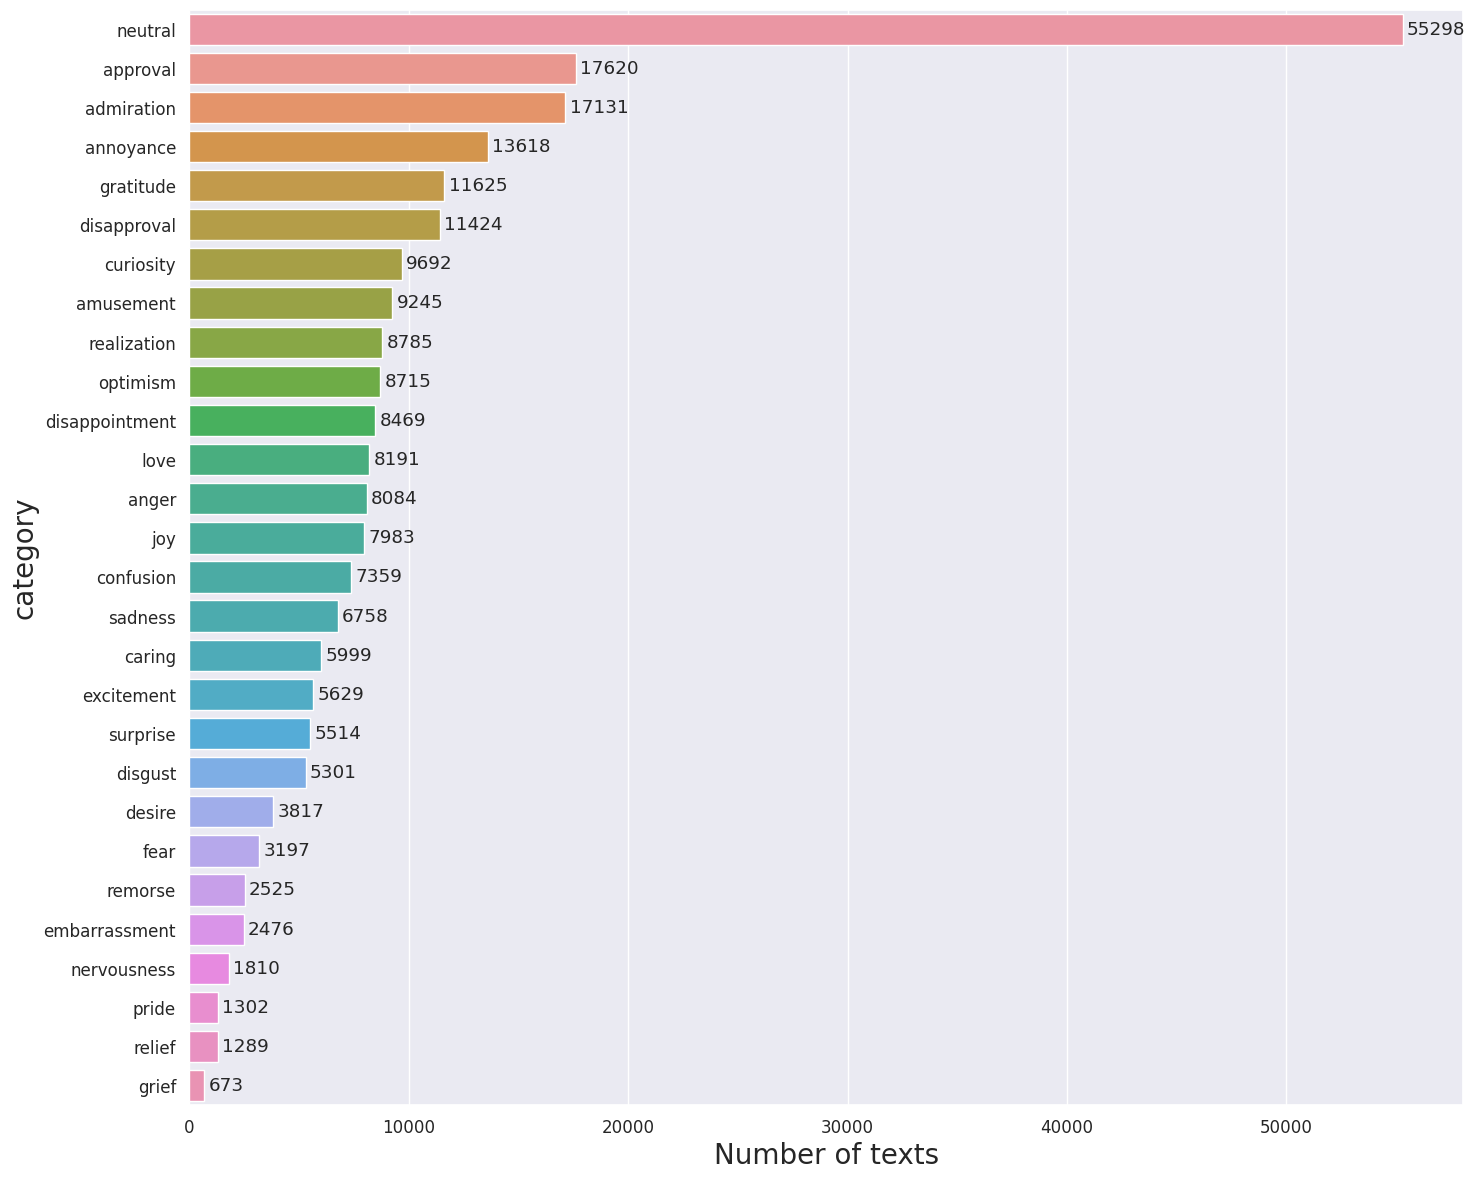

In [6]:
# Calculating number of texts in each category
counts = []
for category in Config.categories:
    counts.append((category, raw_df[category].sum()))
category_counts = pd.DataFrame(counts, columns=['category', 'number of texts'])

category_counts = category_counts.sort_values(by='number of texts', ascending=False) #sort the categories in descending order based on number of texts

#plotting the result
sns.set(font_scale=1.1)
plt.figure(figsize=(15,12))
plt.xlabel('Number of texts', fontsize=20)
plt.ylabel('Category', fontsize=20)

ax=sns.barplot(y = category_counts['category'], x = category_counts['number of texts'].values, orient='h')

rects = ax.patches
labels = category_counts['number of texts'].values
for rect, label in zip(rects, labels):
    width = rect.get_width()
    ax.text(width +200,rect.get_y() + rect.get_height()/2, label, ha='left', va='center')

plt.tight_layout()
#plt.savefig('frequency of each label.png', bbox_inches='tight')
plt.show()


#### 3.2.3. Calculating number of texts having multiple labels

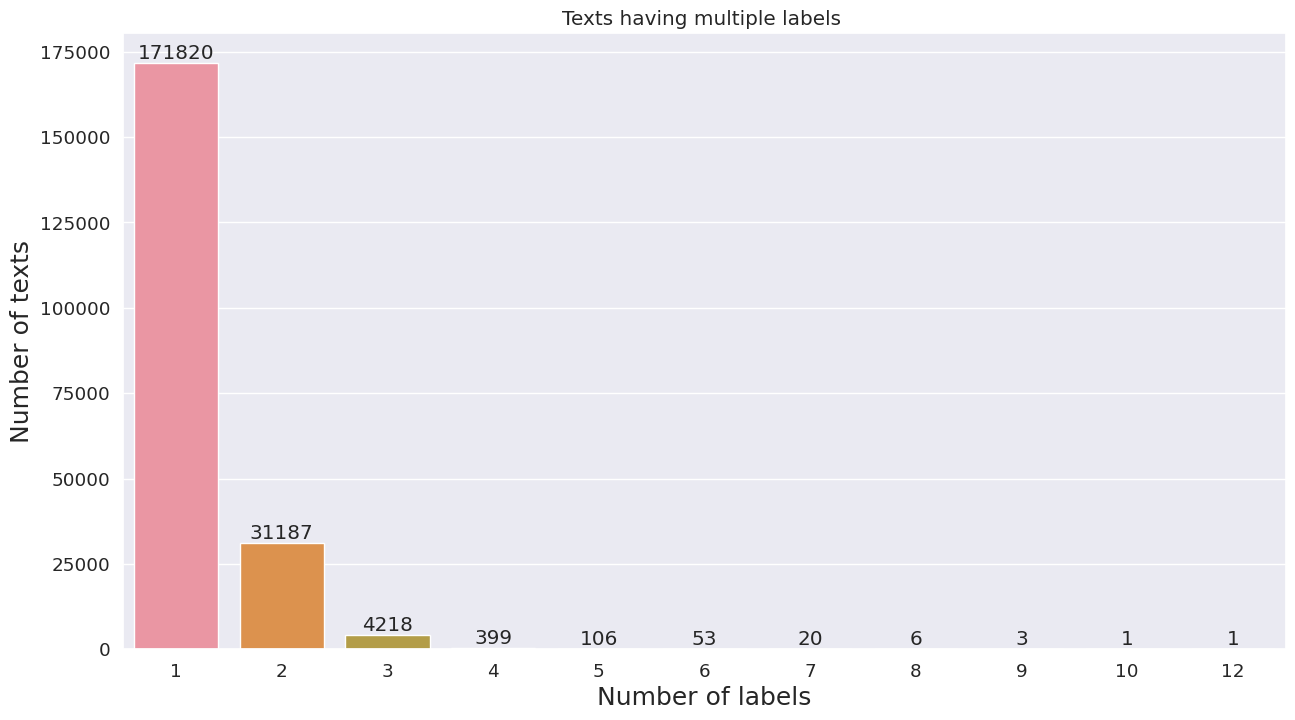

In [7]:
# calculating number of texts having multiple labels

rowSums = raw_df.loc[:, Config.categories].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 1.2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x = multiLabel_counts.index, y = multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### 3.2.4 Visualizing the most frequent words in each category

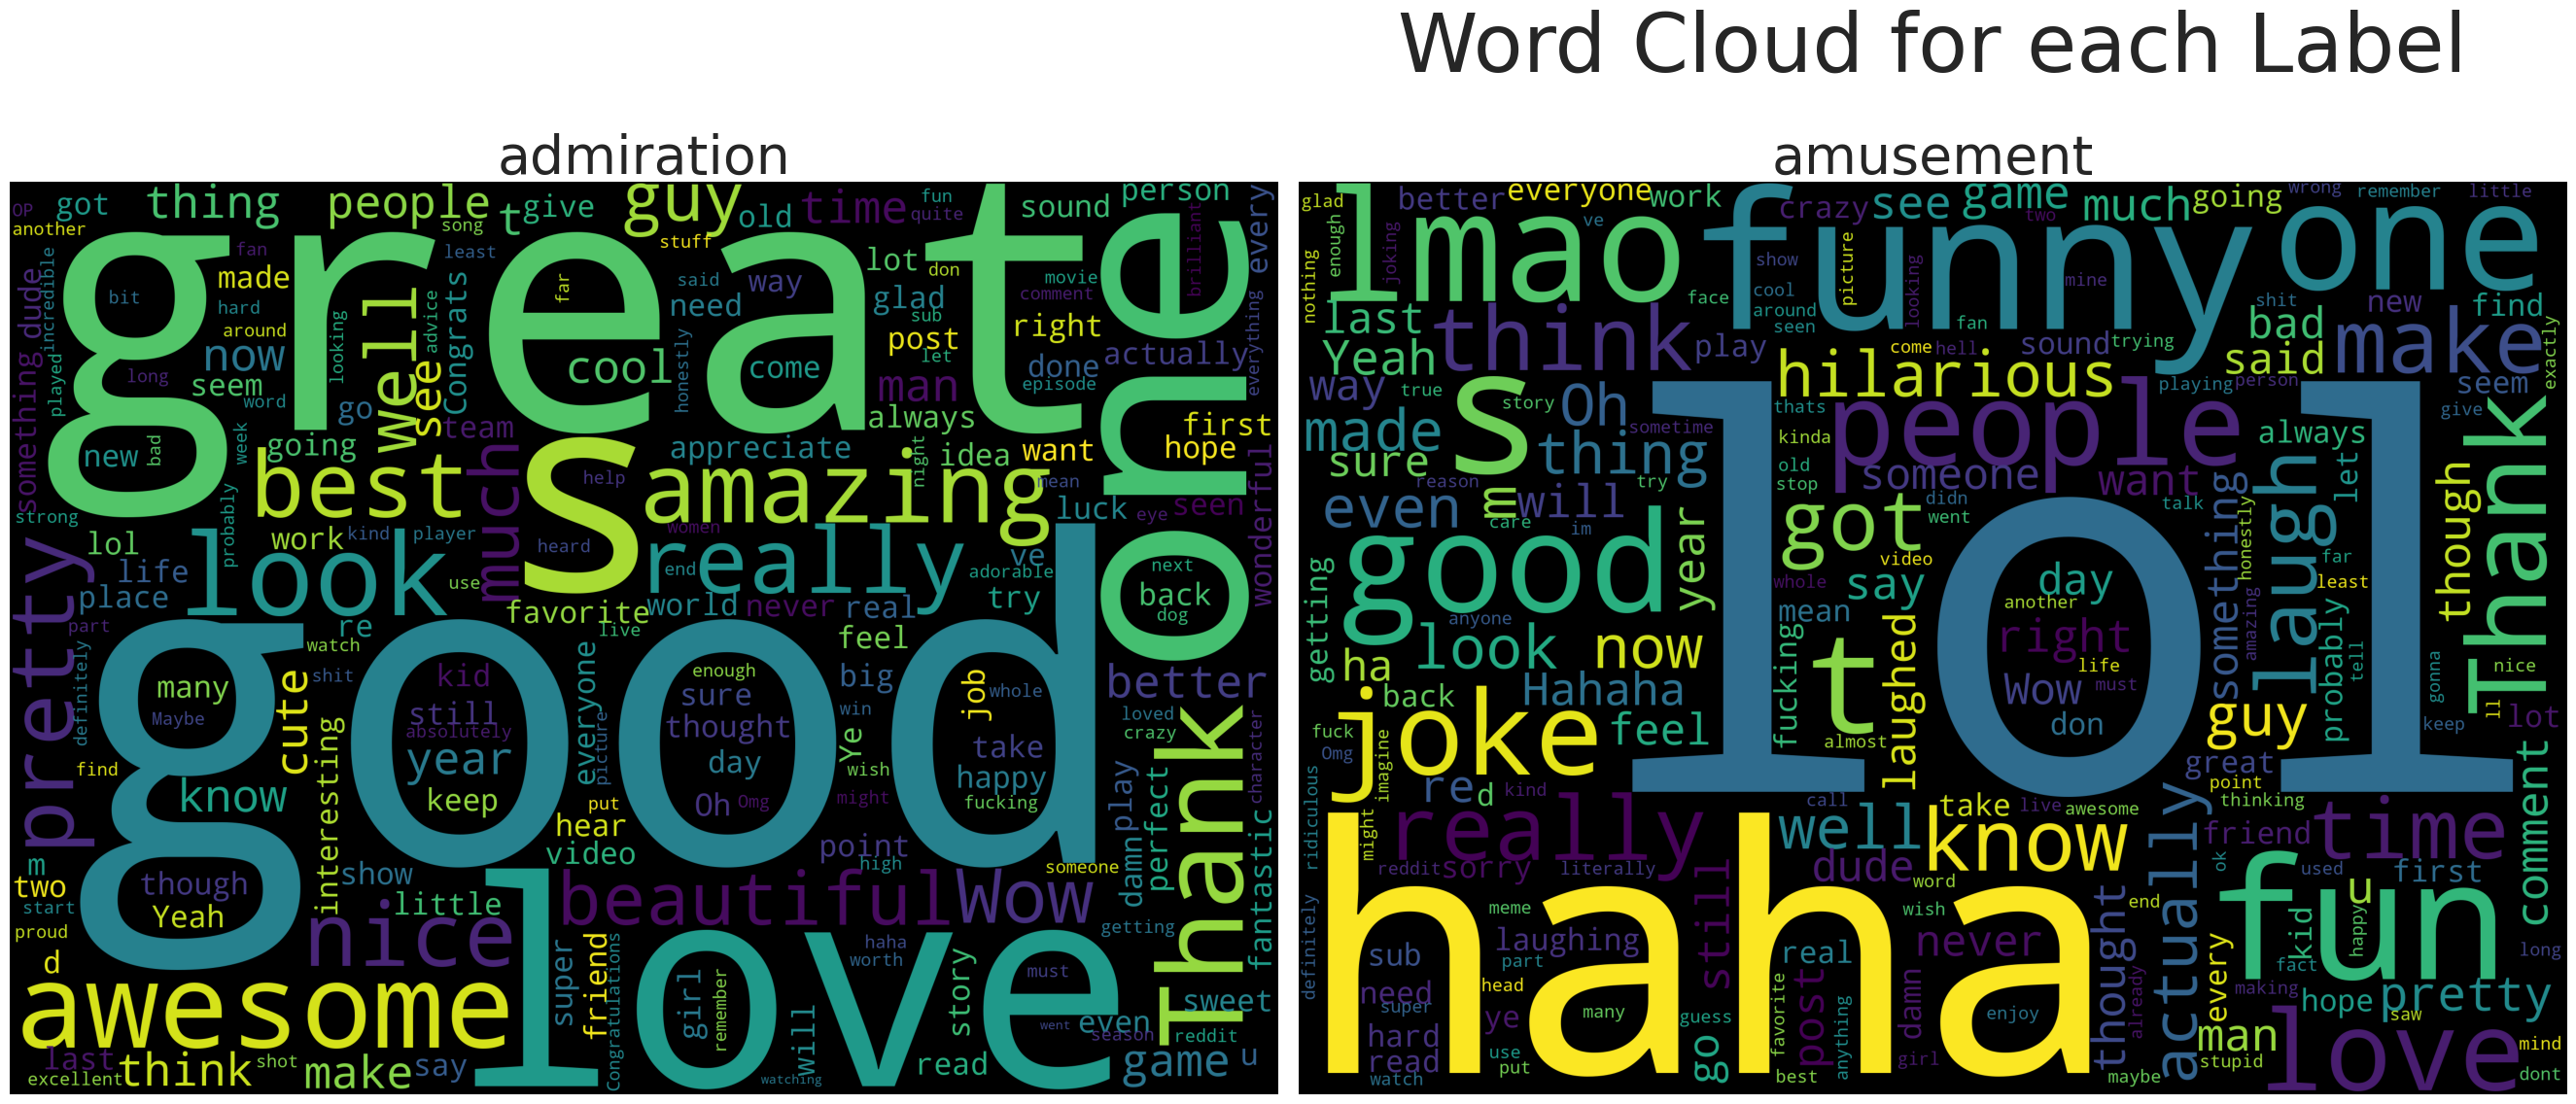

In [8]:
plt.figure(figsize=(40,180))

STOPWORDS.add('NAME')

for i, category in enumerate(Config.categories[:2]): #remove the slice '[:3]' to get wordcloud for all labels
    subset = raw_df[raw_df[category]==1]
    text = subset.text.values
    cloud = WordCloud(stopwords=STOPWORDS,
                            background_color='black',
                            collocations=False,
                            width=500,
                            height=360,
                            scale = 5.0
                            ).generate(" ".join(text))

    plt.subplot(10, 3, i+1)
    plt.axis('off')
    plt.title(category,fontsize=40)
    plt.suptitle('Word Cloud for each Label', fontsize = 60)
    plt.imshow(cloud)
plt.tight_layout()
plt.savefig('WordClouds for each label.png', bbox_inches = 'tight')
plt.show()

### 3.3 Data Subsampling

In [9]:
# for experimentational purpose, we'll select only 4000 samples from the dataset to start with
set_seeds()
sub_df = raw_df.sample(4000).reset_index(drop=True)


### 3.4 Text Preprocessing

In [10]:
def preprocess_text(text):
    if type(text) != str: # replace all non-string inputs with an empty string
        return ''
    
    text = ' '.join([word.lower() if word != '[NAME]' else word for word in text.split()]) # convert to lower case
    text = text.strip()
    
    return text

In [11]:
sub_df.text = sub_df.text.apply(preprocess_text) #apply preprocessing on the texts

labels = sub_df[Config.categories].values

sub_df['labels'] = [labels[i] for i in range(len(sub_df))]
sub_df = sub_df.drop(Config.categories, axis = 1) #drop the categories' columns

### 3.5 Tokenization

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text: str | Dict):
    if not isinstance(text, (str, dict)):
        try:
            text = dict(text)
        except:
            raise ValueError("Input must be str or dict having a key: 'text' containing the text to be tokenized")
        
    if type(text) == dict:
        if 'text' not in text.keys():
            raise ValueError("Input dict must have a key: 'text' containing the text to be tokenized")
    
    if type(text) == str:
        text = {'text': text.lower()}

    tokens = tokenizer(text['text'] if type(text['text']) == str else [sentence.lower() for sentence in text['text']], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    tokens = {k: v.to(Config.device) for k, v in tokens.items()} # move the token tensors to the appropriate device
    return tokens

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 3.6 Creating Datasets and DataLoaders

In [13]:
num_train = int(Config.train_split*len(sub_df))
train_dataset = Dataset.from_pandas(sub_df.iloc[:num_train])
val_dataset = Dataset.from_pandas(sub_df.iloc[num_train:])

In [14]:
train_dataset = train_dataset.map(tokenize, remove_columns = 'text', batched = True)
val_dataset = val_dataset.map(tokenize, remove_columns = 'text', batched = True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [15]:
def custom_collate_fn(batch):
    # Extracting the necessary parts and stacking them correctly
    out_batch = {}
    for key in batch[0].keys():
        out_batch[key] = torch.stack([torch.tensor(item[key]).squeeze() for item in batch])
        
    # Return as a dictionary, ensuring correct shapes
    return out_batch


train_loader = DataLoader(train_dataset, shuffle=True, collate_fn = custom_collate_fn, batch_size = Config.batch_size, num_workers =Config.num_workers, pin_memory=Config.pin_memory, prefetch_factor = Config.prefetch_factor)
val_loader = DataLoader(val_dataset, shuffle=False, collate_fn = custom_collate_fn, batch_size = Config.batch_size, num_workers =Config.num_workers, pin_memory=Config.pin_memory, prefetch_factor = Config.prefetch_factor)


## Modelling

In [16]:
class BertForMultilabelClassification(nn.Module):
    def __init__(self, num_labels: int = Config.num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # Get the pooled output from the last layer
        logits = self.classifier(pooled_output)  # Output logits for each label
        return logits

In [17]:
set_seeds()
model = nn.parallel.DataParallel(BertForMultilabelClassification()).to(Config.device)

# instantiating the loss function
loss_func = nn.BCEWithLogitsLoss().to(Config.device)

# instantiate the accuracy function
acc_fn = Accuracy('multilabel', num_labels = len(Config.categories)).to(Config.device)

# instatiating the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay = Config.weight_decay)

num_training_steps = Config.num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Model Training

### Setting up training configurations

I want to implement early stopping. So a rough sketch of how I could implement this would be:
- Record the average validation loss per batch for each epoch e.g **epoch 1 - `val_loss` = 0.5**
- Store the results for each epoch in a list `val_losses`
- Starting from epoch 2: at the end of each epoch, check to see if the latest `val_loss` in `val_losses` (i.e `val_losses[-1]`) is greater than the `patience` preceeding `val_loss`es (i.e `val_losses[-2: -patience+1 :-1]`)
- If the latest `val_loss` is greater then the immediate preceeding `val_loss`, increment `early_stopping_epoch` by 1
- Check if `early_stopping_epoch` is equal to `patience`. If `True` set `stop_early` to `True`

In [18]:
class TrainConfig(Config):
    def __init__(self):
        super().__init__()
        self.patience = 3
        self.model_savepath = 'bertmodel-mini.pth'
    
class TrainState:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []

### Training loop

In [19]:
trainconfig = TrainConfig()
trainstate = TrainState()

scaler = GradScaler('cuda')
set_seeds()

start = timer()
# training loop
for epoch in range(trainconfig.num_epochs):
    model.train()
    total_loss = 0.
    # training loop
    #iterate through each batches
    for batch in train_loader:
        optimizer.zero_grad()
        
        batch = {k: v.to(Config.device) for k, v in batch.items()}
        with autocast('cuda'):
            logits = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'], token_type_ids = batch['token_type_ids'])

            loss = loss_func(logits, batch['labels'].float())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        
        total_loss += loss.item()
    
    trainstate.train_losses.append(total_loss/len(train_loader))
    
    # validation loop
    model.eval()
    total_loss = 0.
    total_acc = 0.
    
    with torch.inference_mode():
        for batch in val_loader:
            batch = {k: v.to(Config.device) for k, v in batch.items()}
            
            with autocast('cuda'):
                logits = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'], token_type_ids = batch['token_type_ids'])

                loss = loss_func(logits, batch['labels'].float())
                
            acc = acc_fn(logits, batch['labels'])
            total_loss += loss.item()
            total_acc += acc.item()
            
    trainstate.val_losses.append(total_loss/len(val_loader))
    trainstate.val_accs.append(total_acc/len(val_loader))
        
    print(f'Epoch: {epoch + 1} | Train Loss: {trainstate.train_losses[-1]} | Val Loss: {trainstate.val_losses[-1]} | Val Acc: {trainstate.val_accs[-1]}') 
    print('-'*120)
    
    if epoch != 0:
        curr_loss_greater = sum([trainstate.val_losses[-1] > val_loss for val_loss in trainstate.val_losses[-(trainconfig.patience + 1) : -1]])
        
        if curr_loss_greater == 0:
            torch.save(model.state_dict(), trainconfig.model_savepath)
            continue
            
        if curr_loss_greater == trainconfig.patience:
            model.load_state_dict(torch.load(trainconfig.model_savepath, weights_only = True))
            print(f'Best Val Loss: {min(trainstate.val_losses):.3f} | Best Val Accuracy: {max(trainstate.val_accs):.3f}')
            break
            
stop = timer()
print(f'Total time taken: {stop-start:.3f}')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch: 1 | Train Loss: 0.5025396502017975 | Val Loss: 0.31091716034071787 | Val Acc: 0.9576291441917419
------------------------------------------------------------------------------------------------------------------------
Epoch: 2 | Train Loss: 0.25257044613361357 | Val Loss: 0.19983428716659546 | Val Acc: 0.9576291441917419
------------------------------------------------------------------------------------------------------------------------
Epoch: 3 | Train Loss: 0.18984028875827788 | Val Loss: 0.171027666756085 | Val Acc: 0.9576291441917419
------------------------------------------------------------------------------------------------------------------------
Epoch: 4 | Train Loss: 0.17250346064567565 | Val Loss: 0.16199852313314164 | Val Acc: 0.9576291441917419
------------------------------------------------------------------------------------------------------------------------
Epoch: 5 | Train Loss: 0.1666206157207489 | Val Loss: 0.15855544592653 | Val Acc: 0.957629144191741

## Making predictions

In [20]:
def pred_sentiment(text, return_type = 'dict', model:nn.Module = model):
    if return_type not in ['dict', 'list']:
        print('[WARNING] return_type can only be one of (dict, str). Defaulting to dict')
        return_type = 'dict'
        
    threshold = 0.2
    category_idxs = []
    model.eval()
    with torch.inference_mode():
        category_probs = model(**tokenize(text)).sigmoid().squeeze()
    for idx, prob in enumerate(category_probs):
        #print(prob)
        if prob >= threshold:
            category_idxs.append(idx)
            
    if return_type == 'list':
        return [Config.categories[idx] for idx in category_idxs] # return list
    else:
        return {Config.categories[cat]:round(category_probs[cat].item(), 3) for cat in category_idxs} #return dict

In [21]:
pred_sentiment("I HATE YOU!! But I also love you and i don't know why", 'list')

['love']

The model trained on the the data subset (3200) samples seems to perform fairly


## Training the model with the complete GoEmotions dataset

### Text preprocessing

In [22]:
raw_df.text = raw_df.text.apply(preprocess_text) #apply preprocessing on the texts

clean_df = raw_df.copy()

labels = clean_df[Config.categories].values

clean_df['labels'] = [labels[i] for i in range(len(clean_df))]
clean_df = clean_df.drop(Config.categories, axis = 1) #drop the categories' columns

### Creating Dataset and Dataloader

In [23]:
num_train = int(Config.train_split*len(clean_df))
num_val = int(Config.val_split*len(clean_df))

train_dataset = Dataset.from_pandas(clean_df.iloc[:num_train])
val_dataset = Dataset.from_pandas(clean_df.iloc[num_train:num_train+num_val])
test_dataset = Dataset.from_pandas(clean_df.iloc[num_train+num_val:])

In [24]:
train_dataset = train_dataset.map(tokenize, remove_columns = 'text', batched = True, cache_file_name = Config.train_tokenizer_cache_file_name)
val_dataset = val_dataset.map(tokenize, remove_columns = 'text', batched = True, cache_file_name = Config.val_tokenizer_cache_file_name)
test_dataset = test_dataset.map(tokenize, remove_columns = 'text', batched = True, cache_file_name = Config.test_tokenizer_cache_file_name)

Map:   0%|          | 0/166251 [00:00<?, ? examples/s]

Map:   0%|          | 0/20781 [00:00<?, ? examples/s]

Map:   0%|          | 0/20782 [00:00<?, ? examples/s]

In [25]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn = custom_collate_fn, batch_size = Config.batch_size, num_workers =Config.num_workers, pin_memory=Config.pin_memory, prefetch_factor = Config.prefetch_factor)
val_loader = DataLoader(val_dataset, shuffle=False, collate_fn = custom_collate_fn, batch_size = Config.batch_size, num_workers =Config.num_workers, pin_memory=Config.pin_memory, prefetch_factor = Config.prefetch_factor)
test_loader = DataLoader(test_dataset, shuffle=False, collate_fn = custom_collate_fn, batch_size = Config.batch_size, num_workers =Config.num_workers, pin_memory=Config.pin_memory, prefetch_factor = Config.prefetch_factor)

### Modelling

In [26]:
class BertForMultilabelClassification(nn.Module):
    def __init__(self, num_labels: int = Config.num_labels):
        super(BertForMultilabelClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # Get the pooled output from the last layer
        logits = self.classifier(pooled_output)  # Output logits for each label
        return logits

In [27]:
set_seeds()
model = nn.parallel.DataParallel(BertForMultilabelClassification()).to(Config.device)

# instantiating the loss function
loss_func = nn.BCEWithLogitsLoss().to(Config.device)

# instantiate the accuracy function
acc_fn = Accuracy('multilabel', num_labels = len(Config.categories)).to(Config.device)

# instatiating the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay = Config.weight_decay)

num_training_steps = Config.num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### Training

In [28]:
class TrainConfig(Config):
    def __init__(self):
        super().__init__()
        self.patience = 2
        self.model_savepath = 'bertmodel-full.pth'
    
class TrainState:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []

In [29]:
trainconfig = TrainConfig()
trainstate = TrainState()

scaler = GradScaler('cuda')
set_seeds()

# training loop
for epoch in range(trainconfig.num_epochs):
    model.train()
    total_loss = 0.
    # training loop
    #iterate through each batches
    for batch in train_loader:
        optimizer.zero_grad()
        
        batch = {k: v.to(Config.device) for k, v in batch.items()}
        with autocast('cuda'):
            logits = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'], token_type_ids = batch['token_type_ids'])

            loss = loss_func(logits, batch['labels'].float())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        
        total_loss += loss.item()
    
    trainstate.train_losses.append(total_loss/len(train_loader))
    
    # validation loop
    model.eval()
    total_loss = 0.
    total_acc = 0.
    
    with torch.inference_mode():
        for batch in val_loader:
            batch = {k: v.to(Config.device) for k, v in batch.items()}
            
            with autocast('cuda'):
                logits = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'], token_type_ids = batch['token_type_ids'])

                loss = loss_func(logits, batch['labels'].float())
                
            acc = acc_fn(logits, batch['labels'])
            total_loss += loss.item()
            total_acc += acc.item()
            
    trainstate.val_losses.append(total_loss/len(val_loader))
    trainstate.val_accs.append(total_acc/len(val_loader))
        
    print(f'Epoch: {epoch + 1} | Train Loss: {trainstate.train_losses[-1]} | Val Loss: {trainstate.val_losses[-1]} | Val Acc: {trainstate.val_accs[-1]}') 
    print('-'*120)
    
    if epoch != 0:
        curr_loss_greater = sum([trainstate.val_losses[-1] > val_loss for val_loss in trainstate.val_losses[-(trainconfig.patience + 1) : -1]])
        
        if curr_loss_greater == 0:
            torch.save(model.state_dict(), trainconfig.model_savepath)
            continue
            
        if curr_loss_greater == trainconfig.patience:
            model.load_state_dict(torch.load(trainconfig.model_savepath, weights_only = True))
            print(f'Best Val Loss: {min(trainstate.val_losses):.3f} | Best Val Accuracy: {max(trainstate.val_accs):.3f}')
            break
    

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch: 1 | Train Loss: 0.14426064491845536 | Val Loss: 0.11646550582961802 | Val Acc: 0.9613935153908525
------------------------------------------------------------------------------------------------------------------------
Epoch: 2 | Train Loss: 0.11281112960042909 | Val Loss: 0.11259040451305775 | Val Acc: 0.9612710691668505
------------------------------------------------------------------------------------------------------------------------
Epoch: 3 | Train Loss: 0.10630164205959157 | Val Loss: 0.1114487269996134 | Val Acc: 0.9615928797634101
------------------------------------------------------------------------------------------------------------------------
Epoch: 4 | Train Loss: 0.10102965875462076 | Val Loss: 0.11328145020578537 | Val Acc: 0.9611155617456495
------------------------------------------------------------------------------------------------------------------------
Best Val Loss: 0.111 | Best Val Accuracy: 0.962


In [30]:
pred_sentiment("A piece of my heart is always missing when you're not with me")

{'neutral': 0.581}

In [31]:
pred_sentiment("I thought I would love the new restaurant, but the food was just okay and the service was terrible.")

{'admiration': 0.416}

In [32]:
f1_score = F1Score('multilabel', num_labels = Config.num_labels).to(Config.device)
auroc_score = AUROC('multilabel', num_labels = Config.num_labels).to(Config.device)

model.eval()
total_loss = 0.
total_acc = 0.
total_f1score = 0.
total_auroc = 0

with torch.inference_mode():
    for batch in test_loader:
        batch = {k: v.to(Config.device) for k, v in batch.items()}

        with autocast('cuda'):
            logits = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'], token_type_ids = batch['token_type_ids'])

            loss = loss_func(logits, batch['labels'].float())
        probs = (logits>0.2).float()
        acc = acc_fn(probs, batch['labels'])
        
        f1score = f1_score(probs, batch['labels'])
        auroc = auroc_score(probs, batch['labels'])
        
        total_loss += loss.item()
        total_acc += acc.item()
        total_f1score += f1score.item()
        total_auroc += auroc.item()
        
print('Loss: ', total_loss/len(test_loader))
print('Accuracy: ', total_acc/len(test_loader))
print('F1 Score: ', total_f1score/len(test_loader))
print('AUROC: ', total_auroc/len(test_loader))

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Loss:  0.11277603627713911
Accuracy:  0.9617310155388767
F1 Score:  0.32144357035496485
AUROC:  0.5249785919862291


In [33]:
torch.save(model.module.state_dict(), 'BERT_Sentiment_Classification_GOEmotions_noParallel.pth')

model_noParallel = BertForMultilabelClassification().to(Config.device)
model_noParallel.load_state_dict(torch.load('BERT_Sentiment_Classification_GOEmotions_noParallel.pth', weights_only = True))

ex_input = next(iter(val_loader))
ex_input = {k:v.to(Config.device) for k, v in ex_input.items()}

with torch.no_grad():
    traced_model = torch.jit.trace(model_noParallel, (ex_input['input_ids'], ex_input['attention_mask'], ex_input['token_type_ids']))

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [34]:
torch.jit.save(traced_model, 'BERT_Sentiment_Classification_GOEmotions_scripted.pth')